In [46]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from scipy import fft

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# Solving heat equation using spectral methods

Our heat equation is this:

\begin{equation}
\frac{\partial u}{\partial t} = \kappa \nabla^2 u
\end{equation}

We will slove this equation in a square box of legth $L$ first. 

To start solving this equation, we will first have to non-dimenssionalise it. Because computers don't understand the language of units. We need to find the natural length scale which can be easily identified as the length of the rod $L$. Now we define dimenssionless position as $x \to \frac{x}{L}$. Then we need to find the scale for time. If we put the length scale into the equation, we will find that the time scale is $\tau = \frac{L^2}{\kappa}$. Then we define $t \to \frac{t}{\tau}$. We also need to find a temperature scale, which doesn't effect our equation because it is on both side and will cancel out. But still we need to do that. The natural temperature scale is found in the intial  intial distribution of the temperature. Then this $T_0$ can we taken as temperature scale and the dimenssionless temperature would be $T \to T/T_0$. Not that our space domain reduces to just $[0,1]$ in dimenssionless variables. Now we easily write the diffrential equation in dimenssionless variables:

Then our equation becomes 

\begin{equation}
\frac{\partial u}{\partial t} = \nabla^2 u
\end{equation}

To solve this equation, we will take spatial fourier transform on both side of the equation and then the $\nabla$ operator becomes just $-k^2$. So our equation has this form now

\begin{equation}
\frac{\partial \hat{u}}{\partial t} = -k^2 \hat{u}
\end{equation}

Then we can use any kind of integrator to solve this temporal equation, for the simplicity, we will use the Euler's method now, then we can imporve it by using Runge Kutta and other fancy method later. The equation at a later time will look like this"

\begin{equation}
\hat{u}(t+\Delta t) = \hat{u} + \Delta t (-k^2 \hat{u})
\end{equation}

Then we can take inverse fourier tranform to get back to the $u$ at that instant of time. 

Now we need boundary conditions, we will take simple boundary conditions as usual to model. 
The intial temeperature destribution is given by:

$$u(r, 0) =  e^{-r^2}$$

At the edges, the temperature is 0.

$$u(0, y, t) = u(1, y, t) = u(x, 0, t) = u(x, 1, t) = 0$$

Now we start solving the equation

In [51]:
t0 = 0 #intial time
tf = 10 #final time
dt = 1e-2 #time step

Nt = int((tf-t0)/dt) #total number of time steps

Nx = 32 #total number of spatial grid steps
h = 1/Nx #the grid spacing

xs = np.linspace(0,1, Nx)

#making the intial temperature matrix
U = np.zeros((Nx, Nx, Nt), dtype='float64')


def To(x, y):

    # return np.exp(-(x-0.5)**2 - (y-0.5)**2)
    # return 2*np.sin(x*np.pi*3)**2 + 3*np.cos(y*np.pi*3)**2
    # return np.random.uniform(0,1)
    return 0

for i in range(Nx):
    for j in range(Nx):
        x = i*h
        y = j*h
        U[i,j,0] =  To(x,y)
        
# #putting the edges at zero temp
U[0, :, :] = 1
U[-1, :, :] = 0
U[:,0,:] = 0
U[:,-1,:] = 0

In [52]:
plt.pcolormesh(U[:,:,0], cmap=plt.cm.RdBu_r)
plt.show()

In [29]:
#applyting spectral method
for i in range(1,Nt):
    u = U[:, :, i-1]

    u_hat = fft.fft2(u) #taking the fourier transform

    k_x = fft.fftfreq(Nx)*(2*pi/1)
    k_y = fft.fftfreq(Nx)*(2*pi/1)
    
    k_spec = k_x*k_x + k_y*k_y

    u_hat += -k_spec*u_hat*dt

    #taking the inverse fourier tranform
    u_real = np.real(fft.ifft2(u_hat))


    U[:,:,i] = u_real


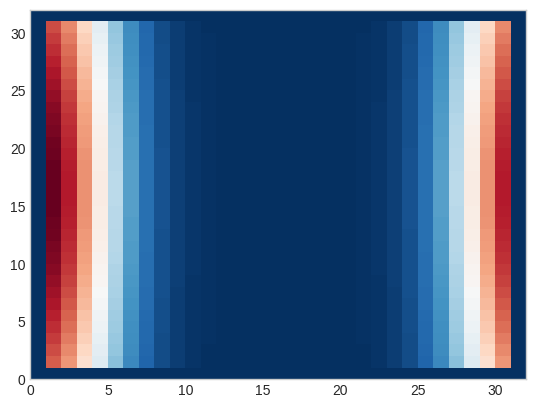

In [44]:
plt.pcolormesh(U[:,:,60], cmap=plt.cm.RdBu_r)
plt.show()

In [54]:
%matplotlib qt
for i in range(Nt):
    if i%10==0:
        plt.clf()
        plt.pcolormesh(U[:,:,i], cmap=plt.cm.RdBu_r, vmin=0, vmax=(1))
        plt.title(f't = {round(i*dt)}')
        plt.pause(0.1)

trying psudo spectral method

### Numerical solutions from pseudo-spectral methods with filtering
In Fourier space, these equations are of the form

$$
\dot{\phi_q} = \alpha(q) \phi_q + \hat{N}_q 
$$

Multiplying both sides by $\exp(−\alpha(k)t)$ gives

$$
\frac{d(\phi_q e^{-\alpha t}) }{dt} =\frac{d \psi }{dt}=  e^{-\alpha t}\hat{N}_q  
%+ e^{-\alpha t}i\mathbf q \cdot \mathbf \Lambda
$$

Thus, we can solve for $\psi_q=\phi_q e^{-\alpha t}$ and then compute 

$$\phi_q (t+dt) = \psi_q (t+dt)e^{\alpha (t+dt)} = \left[\psi_q (t) + dt \left(e^{-\alpha t}
\hat{N}_q \right)\right] e^{\alpha (t+dt)}
$$

This can be simplified to
$$\phi_q (t+dt) = \left[\phi_q (t) + dt\hat{N}_q   \right] e^{\alpha dt}
$$

In our case there is no non-linear term. The nonlinear term is zero so we can proceed with:

$$\phi_q (t+dt) = \left[\phi_q (t)  \right] e^{\alpha dt}
$$

In [53]:
for i in range(1, Nt):
    u = U[:,:, i-1]

    #defining the k space 
    kx = (2*pi/1)*fft.fftfreq(Nx)
    ky = (2*pi/1)*fft.fftfreq(Nx)

    ksq = kx*kx + ky*ky

    alpha = -ksq

    u = u*np.exp(alpha*dt)

    U[:, :, i] = u
